# Average price by room type and City Hall

Our main goal will be to find the average price of an [Airbnb](https://es-l.airbnb.com/) accommodation offered by room type among the 16 City Halls in Mexico city and visualize this data on an interactive map.

All accommodation offered in Airbnb is required to be as one of these room types:

* Entire home/apartment
* Hotel room	
* Private room	
* Shared room

By calculating the average price for one of each of this room types by City Hall, we will be able to find the expensive and cheapper City Hall to get an Airbnb accommodation by room type.

Additionally, we will plot a map with the top accommodations by price.

The results are displayed in [seaborn](https://seaborn.pydata.org/) plots and interactive maps using [folium](https://github.com/python-visualization/folium) to plot geospacial data.

### References:
* [Geospatial Analysis using Folium](https://www.analyticsvidhya.com/blog/2020/06/guide-geospatial-analysis-folium-python/)
* [GeoJson Popup and Tooltip](https://nbviewer.jupyter.org/github/python-visualization/folium/blob/master/examples/GeoJsonPopupAndTooltip.ipynb)
* [Interactive Map visualization with Folium in Python](https://medium.com/@saidakbarp/interactive-map-visualization-with-folium-in-python-2e95544d8d9b)

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import geopandas
import branca
from geopandas import GeoDataFrame
from folium.features import GeoJson, GeoJsonTooltip

### Importing the dataset

Previously we have imported and cleaned the dataset available from [Airbnb Datasets](http://insideairbnb.com/get-the-data.html). 

Clean data set can be found in the project repository [here.](https://github.com/prope-2020-gh-classroom/practica-final-por-equipos-verano-2020-itam-EddOselotl/blob/master/airbnb_clean.csv)

In [2]:
geojson = "https://raw.githubusercontent.com/prope-2020-gh-classroom/practica-final-por-equipos-verano-2020-itam-EddOselotl/master/neighbourhoods.geojson"
### converting the file to geopandas object for mapping
geop = geopandas.read_file(geojson)

Using [pandas](https://pandas.pydata.org/) we can easily group our data set by room type and City Hall and calculate the average price with the [mean](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.aggregate.html) function.

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/prope-2020-gh-classroom/practica-final-por-equipos-verano-2020-itam-EddOselotl/master/airbnb_clean.csv")

In [4]:
desc = df.groupby(['neighbourhood_cleansed','room_type'])['price'].mean().unstack(1)

In [5]:
### group by saved to a new dataframe for plotting
room_type = df.groupby(['room_type','neighbourhood_cleansed'])['price'].mean().reset_index(name ='mean_by_room')

### Using seaborn to plot the distribution

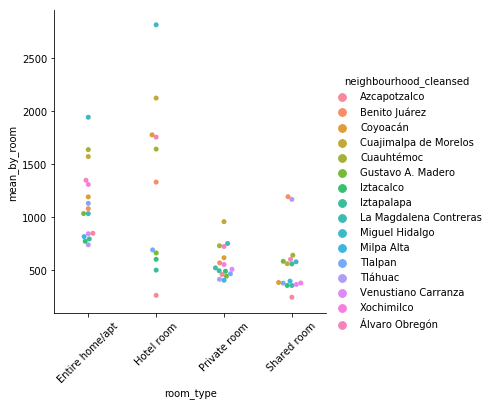

In [6]:
### swarm plot
sns.catplot(x="room_type", y="mean_by_room", hue="neighbourhood_cleansed", kind="swarm", data=room_type).set_xticklabels(rotation=45);

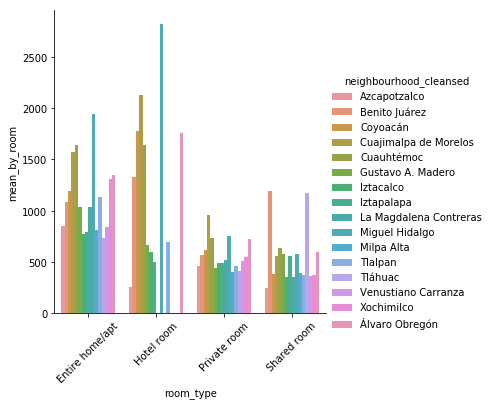

In [7]:
### bar plot
sns.catplot(x="room_type", y="mean_by_room", hue="neighbourhood_cleansed", kind="bar", data=room_type).set_xticklabels(rotation=45);

Next step will be to merge into one data frame mean prices by room type and the accommodations available per category by City Hall and map the data.

In [8]:
count = df.groupby(['neighbourhood_cleansed','room_type'])['id'].count().unstack(1)
desc.reset_index(level=0, inplace=True)
count.reset_index(level=0, inplace=True)

In [9]:
merged = pd.merge(left=desc, right=count, on='neighbourhood_cleansed')
merged.rename(columns = {'neighbourhood_cleansed':'neighbourhood','Entire home/apt_x':'Entire home/apt mean','Hotel room_x':'Hotel room mean',
                    'Private room_x':'Private room mean','Shared room_x':'Shared room mean','Entire home/apt_y':'Entire home/apt count',
                    'Hotel room_y':'Hotel room count','Private room_y':'Private room count','Shared room_y':'Shared room count'}, inplace = True)

### Using Folium and Geopandas to create interative map

We create one map for each one of the room types:

* Entire home/apt
* Hotel room
* Private room
* Shared room

In [10]:
#### Entire home/apt map
home_apt = merged[['neighbourhood','Entire home/apt mean', 'Entire home/apt count']]
home_apt = pd.merge(left = home_apt, right = geop, on = 'neighbourhood')
home_apt.drop(home_apt.columns[[3]], axis=1, inplace=True)
gdf = GeoDataFrame(home_apt, crs = "EPSG:4326", geometry = home_apt.geometry)

colormap = branca.colormap.LinearColormap(
    vmin = gdf['Entire home/apt mean'].quantile(0.0), 
    vmax = gdf['Entire home/apt mean'].quantile(1.0), 
    colors = ['darkgreen','green','lightblue','blue','yellow','orange','red'],
    caption = "Airbnb Entire home/apt mean price by City Hall",
)
m = folium.Map(location = [19.451054, -99.125519], 
               default_zoom_start = 5,
               tiles="Cartodb Positron")

tooltip = GeoJsonTooltip(
    fields = ["neighbourhood","Entire home/apt mean", "Entire home/apt count"],
    aliases = ["City Hall:", "Mean Price:", "Total Accommodations:"],
    localize = True,
    sticky = False,
    labels = True,
    style = """
        background-color: #F0EFEF;
        border: 2px solid black;
        border-radius: 3px;
        box-shadow: 3px;
    """,
    max_width=800,
)
g = folium.GeoJson(
    gdf,
    style_function=lambda x: {
        "fillColor": colormap(x["properties"]["Entire home/apt mean"])
        if x["properties"]["Entire home/apt mean"] is not None
        else "transparent",
        "color": "black",
        "fillOpacity": 0.4,
    },
    tooltip = tooltip
).add_to(m)

colormap.add_to(m)

m

In [11]:
#### Hotel room map
hotel = merged[['neighbourhood','Hotel room mean', 'Hotel room count']]
hotel = pd.merge(left = hotel, right = geop, on = 'neighbourhood')
hotel.drop(hotel.columns[[3]], axis=1, inplace=True)
gdf = GeoDataFrame(hotel, crs = "EPSG:4326", geometry = home_apt.geometry)

colormap = branca.colormap.LinearColormap(
    vmin = gdf['Hotel room mean'].quantile(0.0), 
    vmax = gdf['Hotel room mean'].quantile(1.0), 
    colors = ['darkgreen','green','lightblue','blue','yellow','orange','red'],
    caption = "Airbnb Hotel room mean price by City Hall",
)
m = folium.Map(location = [19.451054, -99.125519], 
               default_zoom_start = 5,
               tiles="Cartodb Positron")

tooltip = GeoJsonTooltip(
    fields = ["neighbourhood","Hotel room mean", "Hotel room count"],
    aliases = ["City Hall:", "Mean Price:", "Total Accommodations:"],
    localize = True,
    sticky = False,
    labels = True,
    style = """
        background-color: #F0EFEF;
        border: 2px solid black;
        border-radius: 3px;
        box-shadow: 3px;
    """,
    max_width=800,
)
folium.GeoJson(
    gdf,
    style_function=lambda x: {
        "fillColor": colormap(x["properties"]["Hotel room mean"])
        if x["properties"]["Hotel room mean"] is not None
        else "transparent",
        "color": "black",
        "fillOpacity": 0.4,
    },
    tooltip = tooltip
).add_to(m)

colormap.add_to(m)

m

In [12]:
#### Private room map
room = merged[['neighbourhood','Private room mean', 'Private room count']]
room = pd.merge(left = room, right = geop, on = 'neighbourhood')
room.drop(room.columns[[3]], axis=1, inplace=True)
gdf = GeoDataFrame(room, crs = "EPSG:4326", geometry = home_apt.geometry)

colormap = branca.colormap.LinearColormap(
    vmin = gdf['Private room mean'].quantile(0.0), 
    vmax = gdf['Private room mean'].quantile(1.0), 
    colors = ['darkgreen','green','lightblue','blue','yellow','orange','red'],
    caption = "Airbnb Private room mean price by City Hall",
)
m = folium.Map(location = [19.451054, -99.125519], 
               default_zoom_start = 5,
               tiles="Cartodb Positron")

tooltip = GeoJsonTooltip(
    fields = ["neighbourhood","Private room mean", "Private room count"],
    aliases = ["City Hall:", "Mean Price:", "Total Accommodations:"],
    localize = True,
    sticky = False,
    labels = True,
    style = """
        background-color: #F0EFEF;
        border: 2px solid black;
        border-radius: 3px;
        box-shadow: 3px;
    """,
    max_width=800,
)
folium.GeoJson(
    gdf,
    style_function=lambda x: {
        "fillColor": colormap(x["properties"]["Private room mean"])
        if x["properties"]["Private room mean"] is not None
        else "transparent",
        "color": "black",
        "fillOpacity": 0.4,
    },
    tooltip = tooltip
).add_to(m)

colormap.add_to(m)

m

In [13]:
#### Shared room map
shared = merged[['neighbourhood','Shared room mean', 'Shared room count']]
shared = pd.merge(left = shared, right = geop, on = 'neighbourhood')
shared.drop(room.columns[[3]], axis=1, inplace=True)
gdf = GeoDataFrame(shared, crs = "EPSG:4326", geometry = home_apt.geometry)

colormap = branca.colormap.LinearColormap(
    vmin = gdf['Shared room mean'].quantile(0.0), 
    vmax = gdf['Shared room mean'].quantile(1.0), 
    colors = ['darkgreen','green','lightblue','blue','yellow','orange','red'],
    caption = "Airbnb Shared room mean price by City Hall",
)
m = folium.Map(location = [19.451054, -99.125519], 
               default_zoom_start = 5,
               tiles="Cartodb Positron")

tooltip = GeoJsonTooltip(
    fields = ["neighbourhood","Shared room mean", "Shared room count"],
    aliases = ["City Hall:", "Mean Price:", "Total Accommodations:"],
    localize = True,
    sticky = False,
    labels = True,
    style = """
        background-color: #F0EFEF;
        border: 2px solid black;
        border-radius: 3px;
        box-shadow: 3px;
    """,
    max_width=800,
)
folium.GeoJson(
    gdf,
    style_function=lambda x: {
        "fillColor": colormap(x["properties"]["Shared room mean"])
        if x["properties"]["Shared room mean"] is not None
        else "transparent",
        "color": "black",
        "fillOpacity": 0.4,
    },
    tooltip = tooltip
).add_to(m)

colormap.add_to(m)

m

# Conclusions

After the analysis of $21572$ Airbnb accommodations offered in Mexico City, based on the mean price for each of the four accommodations and by City Halls, we conclude the following:

In [14]:
### dataframe grouped by City Hall and room type with index as City Hall
tops = df.groupby(['neighbourhood_cleansed','room_type'])['price'].mean().unstack(1)

#### Expensive City Hall accommodations by room type

In [15]:
tops.idxmax(0)

room_type
Entire home/apt           Miguel Hidalgo
Hotel room                Miguel Hidalgo
Private room       Cuajimalpa de Morelos
Shared room                Benito Juárez
dtype: object

#### Cheappest City Hall accommodations by room type

In [16]:
tops.idxmin()

room_type
Entire home/apt         Tláhuac
Hotel room         Azcapotzalco
Private room         Milpa Alta
Shared room        Azcapotzalco
dtype: object

As we can see, Miguel Hidalgo City Hall leads in both expensive room types categories. on the other side, Azcapotzalco leads in two cheapper room types categories. Looking at the map, these two City Halls are side by side one from the other and both are close to Mexico city downtown. So based only on the mean price by room type, we would recommend to some foreign visitor to reserve an Airbnb accommodation in Azcapotzalco City Hall. See Heat map below.

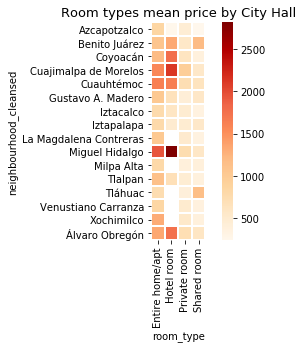

In [17]:
plt.title("Room types mean price by City Hall", fontsize = 13)
sns.heatmap(tops, square=True, cbar_kws={'fraction' : 0.3}, cmap='OrRd', linewidth=1);

Next we present the accommodations offered by City Hall and room type

In [18]:
counts = df.groupby(['neighbourhood_cleansed','room_type'])['id'].count().unstack(1)

#### City Hall with more accommodations by room type

In [19]:
counts.idxmax(0)

room_type
Entire home/apt    Cuauhtémoc
Hotel room         Cuauhtémoc
Private room       Cuauhtémoc
Shared room        Cuauhtémoc
dtype: object

#### City Hall with less accommodations by room type

In [20]:
counts.idxmin(0)

room_type
Entire home/apt      Milpa Alta
Hotel room         Azcapotzalco
Private room         Milpa Alta
Shared room          Milpa Alta
dtype: object

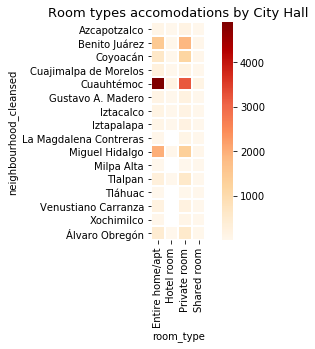

In [21]:
plt.title("Room types accomodations by City Hall", fontsize = 13)
sns.heatmap(counts, square=True, cbar_kws={'fraction' : 0.3}, cmap='OrRd', linewidth=1);

### Top Airbnb accommodations in Mexico City

We present the top Airbnb accommodations in Mxico City based only in the score rating received.

We only plot those accommodations with 99 or 100 score rating on a $0-100$ basis

In [22]:
top_scores = df.loc[df['review_scores_rating'] > 98]

In [23]:
f = folium.Figure(width=30, height=50)
m = folium.Map(location = [19.451054, -99.125519], default_zoom_start = 5)
folium.GeoJson(
    gdf,
     style_function=lambda feature: {
        'fillColor': 'gery',
        'color' : 'black',
        'weight' : 1,
        'fillOpacity' : 0.3,
        }
).add_to(m)

for index, row in top_scores.iterrows():
    tooltip = 'City Hall: {}<br>Room Type: {}<br>Square Feet: {}<br>Price: ${}mxp'.format(row['neighbourhood_cleansed'],row["room_type"],row["square_feet"],row['price'])
    folium.Circle(
        location=[row["latitude"],row["longitude"]],
        tooltip = tooltip,
        radius = 10,
        fill = True,
    ).add_to(m)
m